In [38]:
from glob import glob
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from HOTRG import get_lattice_size,get_dist_torus_2D,get_dist_2D
from scipy.optimize import curve_fit,minimize
from correlation_ansatzs import loglog,get_low_temp_correlation_known_m0,critical_correlation,high_temp_correlation
from tqdm.auto import tqdm

def process_data(data,m0=0,log2Size=30):
    lattice_size=get_lattice_size(nLayers=2*log2Size,spacial_dim=2)
    data['x']=data.apply(lambda row:row['x1']-row['x0'],axis=1)
    data['y']=data.apply(lambda row:row['y1']-row['y0'],axis=1)
    data['dist']=data.apply(lambda row:get_dist_torus_2D(row['x'],row['y'],lattice_size),axis=1)
    data['theta']=data.apply(lambda row:np.arctan2(row['y'],row['x']),axis=1)
    data['correlation_shifted']=data['correlation']-m0**2
    data=data.sort_values(by=['dist'])
    return data

def fitWithHuberLoss(ansatz,x,y,w=None,p0=None,epsilon=1,
                     bounds=None,
                             allow_positive_outliers=True,allow_negative_outliers=True):
    def loss(xs,ys,*p):
        dist=ys-ansatz(xs,*p)
        loss1=1/2 * dist**2 # lsq
        loss2=epsilon*(np.abs(dist)-epsilon/2) # huber
        if allow_positive_outliers:
            loss1[dist>epsilon]=loss2[dist>epsilon]
        if allow_negative_outliers:
            loss1[dist<-epsilon]=loss2[dist<-epsilon]
        return np.sum(loss1*w)
    w=w if w is not None else np.ones_like(x)
    xfit,yfit=x,y
    res=minimize(lambda p: loss(xfit,yfit,*p),p0,method='Nelder-Mead',tol=1e-6,bounds=bounds)
    p=res.x
    return p


def fit_data(ansatz,x,y,w=None,
             huber_epsilon=1e-1,
             x_min=None,x_max=None,
            y_min=None,y_max=None,
            bounds=None,allow_positive_outliers=True,allow_negative_outliers=True,
                use_loglog=True):
    x,y=np.array(x),np.array(y)
    w=np.array(w) if w is not None else np.ones_like(x)
    if x_min is not None:x,y,w=x[x>x_min],y[x>x_min],w[x>x_min]
    if x_max is not None:x,y,w=x[x<x_max],y[x<x_max],w[x<x_max]
    if y_min is not None:x,y,w=x[y>y_min],y[y>y_min],w[y>y_min]
    if y_max is not None:x,y,w=x[y<y_max],y[y<y_max],w[y<y_max]
    
    if use_loglog:
        x,y=x[x>0],y[x>0];x,y=x[y>0],y[y>0]
        print("number of data points:",len(x))
        logx,logy=np.log(x),np.log(y)
        p=tuple(ansatz.p0)
        # p,_=curve_fit(loglog(ansatz),logx,logy,w=w,p0=p,maxfev=10000)
        # print('coarse fitted parameters:',p)
        p=fitWithHuberLoss(loglog(ansatz),logx,logy,w=w,p0=p,epsilon=huber_epsilon,bounds=bounds,
                          allow_positive_outliers=allow_positive_outliers,
                          allow_negative_outliers=allow_negative_outliers)
    else:
        p=tuple(ansatz.p0)
        # p,_=curve_fit(ansatz,x,y,w=w,p0=ansatz.p0,maxfev=10000,bounds=bounds)
        p=fitWithHuberLoss(ansatz,x,y,w=w,p0=p,epsilon=huber_epsilon,bounds=bounds,
                          allow_positive_outliers=allow_positive_outliers,
                          allow_negative_outliers=allow_negative_outliers)
    print('fitted parameters:',p)
    print('fitted equation:',ansatz.eq.format(*p))
    return p,ansatz

In [21]:
beta_critical=0.44068381958007813


names=sorted([os.path.basename(x)[0:-4] for x in glob('./data/hotrg_gilt_X24_betas/*.pth')])
names=[x for x in names if x.replace('.','').replace('-','').isdigit()]
names=names[::-1]
betas=[float(x) for x in names]

data=[]
for beta,name in tqdm(list(zip(betas,names))):
    if not os.path.exists('./data/hotrg_gilt_X24_betas/'+name+'_observables.csv')\
        or not os.path.exists('./data/hotrg_gilt_X24_betas/'+name+'_correlation.pkl'):
        continue

    data_obs=pd.read_csv('./data/hotrg_gilt_X24_betas/'+name+'_observables.csv')
    m0=data_obs['magnetization'].iloc[-1]

    data_corr=pd.read_pickle('./data/hotrg_gilt_X24_betas/'+name+'_correlation.pkl')
    if os.path.exists('./data/hotrg_gilt_X24_betas/'+name+'_correlation_appended.pkl'):
        data_corr=pd.concat([data_corr,pd.read_pickle('./data/hotrg_gilt_X24_betas/'+name+'_correlation_appended.pkl')])
    data_corr=process_data(data_corr,m0=m0)
    data_corr['m0']=m0
    data.append(data_corr)
data=pd.concat(data)


  0%|          | 0/55 [00:00<?, ?it/s]

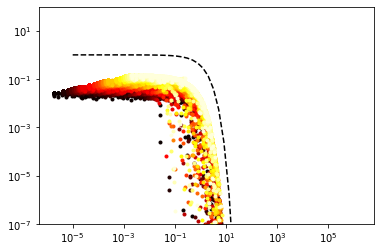

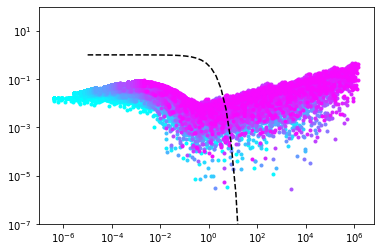

In [67]:
# correlation_scaling_hypothesis
# Lectures on Phase Transitions and the Renormalization Group by Nigel Goldenfeld
# G(r,t)=1/r^(2(d-yh)) FG(r t^(1/yt)) # eq 9.33
# mu=1/yt, 2(d-yh)=d-2+eta, Delta=yh/yt
# G(r,t)=1/r^(d-2+eta) FG(r t^mu)
# https://en.wikipedia.org/wiki/Ising_critical_exponents
# 2D Ising mu=1, eta=1/4
# yt=1, yh=15/8, Delta=15/8, 2(d-yh)=1/4

Delta=0.125
mu=1

data['tau']=(beta_critical-data['beta'])/data['beta']
data['dist_rem']=data['dist']*np.abs(data['tau'])**mu
data['correlation_rem']=data['correlation_shifted']*data['dist_rem']**(2*Delta)


plt.figure()
cmap=matplotlib.cm.get_cmap('hot')
taus=sorted(data['tau'][data['tau']>0].unique())
for i,tau in enumerate(taus):
    data_tau=data[data['tau']==tau]
    plt.plot(data_tau['dist_rem'],data_tau['correlation_rem'],'.',color=cmap(i/len(taus)),label=f'tau={tau:.2f}')
x=np.geomspace(1e-5,1e5)
plt.plot(x,np.exp(-x),'--',label='exp(-x)',color='black')
plt.xscale('log');plt.yscale('log')
plt.ylim(1e-7,1e2)
plt.show()

plt.figure()
cmap=matplotlib.cm.get_cmap('cool')
taus=sorted(data['tau'][data['tau']<0].unique(),reverse=True)
for i,tau in enumerate(taus):
    data_tau=data[data['tau']==tau]
    plt.plot(data_tau['dist_rem'],data_tau['correlation_rem'],'.',color=cmap(i/len(taus)),label=f'tau={tau:.2f}')
x=np.geomspace(1e-5,1e5)
plt.plot(x,np.exp(-x),'--',label='exp(-x)',color='black')
plt.xscale('log');plt.yscale('log')
plt.ylim(1e-7,1e2)
plt.show()